#**Практическое задание №1**

Установка необходимых пакетов:

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://repo.huaweicloud.com/repository/pypi/simple
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14931 sha256=6e9b18e8fd38a7035a1ae5682a805e3dba823dc1638913e5455a111e1b515411
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2lsvgij/wheels/cf/eb/07/335ca3c459e77dc72515044f9c7e5cae0faf186992b1779719
Successfully built gdown


Монтирование Вашего Google Drive к текущему окружению:

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [2]:
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [3]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [4]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False 
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

# load all the data

In [5]:
# d_train = Dataset('train')
d_test = Dataset('test')
# d_train_small = Dataset('train_small')
# d_test_small = Dataset('test_small')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr
To: /content/test.npz
100%|██████████| 525M/525M [00:06<00:00, 83.3MB/s]


Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


Downloading...
From: https://drive.google.com/uc?id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:02<00:00, 42.8MB/s]


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 7.
Label code corresponds to STR class.


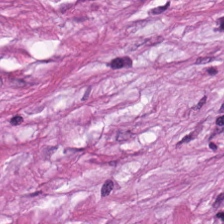

In [ ]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

Downloading...
From: https://drive.google.com/uc?id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 29.1MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


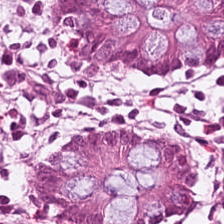

6


In [ ]:
d_test_tiny = Dataset('test_tiny')
img_t,lab_t = d_test_tiny.random_image_with_label()
pil_img_t = Image.fromarray(img_t)
IPython.display.display(pil_img_t)
print(lab_t)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt 
import itertools

In [7]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt) 

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

    @staticmethod
    def plot_confusion_matrix(truelabel,predictions,
                          target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens,
                          normalize=True):
            
        cm = confusion_matrix(y_true=truelabel, y_pred=predictions)
        accuracy = np.trace(cm) / float(np.sum(cm))
        misclass = 1 - accuracy

        if cmap is None:
            cmap = plt.get_cmap('Blues')

        plt.figure(figsize=(15, 12))
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()

        if target_names is not None:
            tick_marks = np.arange(len(target_names))
            plt.xticks(tick_marks, target_names, rotation=45)
            plt.yticks(tick_marks, target_names)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
        plt.show()

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [ ]:
 !pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 32.0 MB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 


In [8]:
import os 
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
# import keras_tuner as kt 
#for auto-choice super parameter 
from tensorflow.keras.applications import EfficientNetB0

In [12]:
class Model():
    def __init__(self,units_dense=512,int_drop=0.3,if_add_dense = False):
        # Transfer Learning 
        self.pre_trained_model = tf.keras.applications.resnet_v2.ResNet101V2(
            input_shape=(224,224,3), include_top=False, weights='imagenet')

        self.pre_trained_model.trainable = False
        for layer in self.pre_trained_model.layers:
            layer.trainable = False
        self.history_1 = None
        self.history_2 = None  
        self.preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
        self.global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

        self.prediction_layer = tf.keras.layers.Dense(9, activation='softmax')
        self.inputs = tf.keras.Input(shape=(224, 224, 3))

        #LBL 11 Использование аугментации и других способов синтетического расширения набора данных 
        #(дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
        self.data_augmentation_layer = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomFlip('vertical'),
            tf.keras.layers.RandomRotation(0.2),
            ])
        
        #    When using this two augmentation, the RAM is not enough to train model on Full dataset on Google Colab
        #   Maybe it can be solved by reducing batch_size
        
        #### Full Model

        x = self.data_augmentation_layer(self.inputs)
        x = self.preprocess_input(x)
        x = self.pre_trained_model(x, training=False)
        x = self.global_average_layer(x)
        x = tf.keras.layers.Dropout(int_drop)(x)
        if if_add_dense==True:
          x = tf.keras.layers.Dense(units_dense, activation='relu')(x)
        
        outputs = self.prediction_layer(x)
        self.model = tf.keras.Model(self.inputs, outputs)


    def save(self, name: str):
        self.model.save(f'drive/MyDrive/{name}.h5')

    def load(self, name: str):
        name_to_id_dict = {
            'train_small':'1824SN6gT9wkyUe75ZZrEHoLMs0Xo4ulq',
            'best': '1gQjfffSbBT1iUJxizPIT1wYzZAyBYbeJ',
            'test': '1Jj_nUS8slUCm-_7ljZ3dEG_7kZ7fmjED'
        }
        url = f'https://drive.google.com/uc?export=download&confirm=pbef&id={name_to_id_dict[name]}'
        gdown.download(url, quiet=False, output=name, use_cookies=False) 
        # url =f'https://drive.google.com/drive/folders/{name_to_id_dict[name]}'
        # gdown.download_folder(url, quiet=True, output=name,use_cookies=False)

        self.model = tf.keras.models.load_model(name)

    def train(self, dataset: Dataset,if_Train_top_layers = False):
        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy'])
        
        #LBL1 Валидация модели на части обучающей выборки
        x_train, x_lab, y_train, y_lab = train_test_split(dataset.images, dataset.labels,
                                                          test_size=0.2, random_state=22)
        
        #LBL3 Автоматическое сохранение модели при обучении
        checkpoint_filepath = 'drive/MyDrive/tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_accuracy',
                mode='max',
                save_best_only=True)
        
        del dataset
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
        print(f'training started')
        #LBL7 Автоматическое тестирование на тестовом 
        #наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения)

        self.history_1 = self.model.fit(x_train, y_train,
                                epochs=5,
                                validation_data=(x_lab, y_lab),callbacks=[model_checkpoint_callback,stop_early],
                                verbose = 2)
        if if_Train_top_layers == True :
        # Unfrezze
          print("Second Training started")
          for layer in self.model.layers[-40:]:
              if not isinstance(layer, layers.BatchNormalization):
                  layer.trainable = True

          self.model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
                      metrics=['accuracy'])

          self.history_2 = self.model.fit(x_train, y_train,
                                  epochs=15,
                                  validation_data=(x_lab, y_lab),callbacks=[model_checkpoint_callback,stop_early],
                                  verbose = 2)
          # to-do
          sleep(2)
        print('training done')
        
    def train_plot(self,history_1_or_2=None):
        if history_1_or_2 is None:
          print("Please history 1 or 2")
          return 
        elif history_1_or_2 == 1:
          history = self.history_1
        else:
          history = self.history_1
        
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(acc))
        plt.plot(epochs,acc,'*',label = "Training accuracy")
        plt.plot(epochs,val_acc,'b',label="Validation accuracy")
        plt.title("Training and validation accuracy")
        plt.legend()
        plt.figure()
        
        plt.plot(epochs,loss,'bo',label = "Training Loss")
        plt.plot(epochs,val_loss,'b',label = "Validation Loss")
        plt.title("training and validation loss")
        plt.legend()
        plt.xlabel('Epoch')
        plt.show() 

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img: np.ndarray):
        img = img.reshape(1,224,224,3)
        prediction = self.model(img, training=False)
        label = tf.argmax(prediction[0])
        return label


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [10]:
model = Model()
model.model = tf.keras.models.load_model('drive/MyDrive/bestone')

171317808/171317808 [==============================] - 1s 0us/step


In [11]:
model.save('best')

In [14]:
model = Model()
if not EVALUATE_ONLY:
    model.train(d_train)
    model.save('best')
else:
    model.load('best')
    test_res = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels[:len(test_res)],test_res, 'test on 100% test')

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1gQjfffSbBT1iUJxizPIT1wYzZAyBYbeJ
To: /content/best
100%|██████████| 171M/171M [00:00<00:00, 268MB/s]


  0%|          | 0/4500 [00:00<?, ?it/s]

metrics for test on 100% test:
	 accuracy 0.9678:


	 balanced accuracy 0.9678:


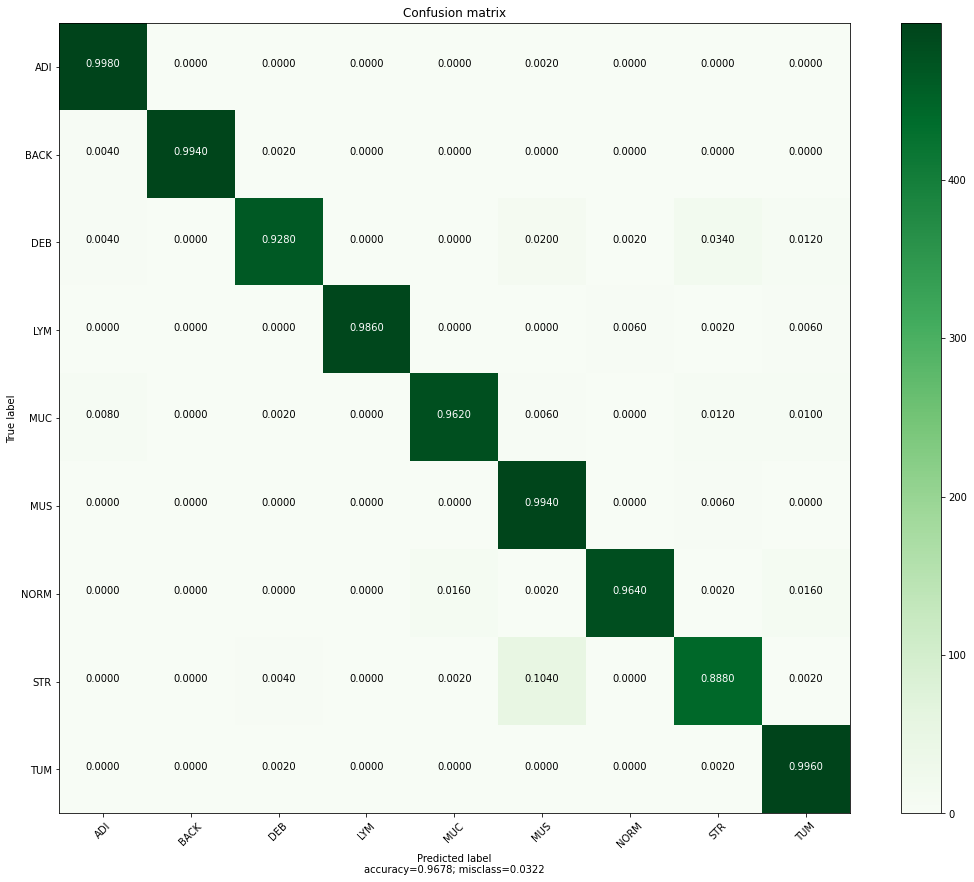

In [ ]:
#LBL8 Построение матрицы ошибок, оценивание чувствительности и специфичности модели
Metrics.plot_confusion_matrix(d_test.labels,test_res,TISSUE_CLASSES)

## LBL9 Автоматический выбор гиперпараметров модели во время обучения
At first By using keras-tuner and train_tiny to choice appropriate superparameter 

In [ ]:
def build_model(hp):

    pre_trained_model = tf.keras.applications.resnet_v2.ResNet101V2(
    input_shape=(224,224,3), include_top=False, weights='imagenet')
    pre_trained_model.trainable = False
    for layer in pre_trained_model.layers:
        layer.trainable = False
        
    preprocess_input = tf.keras.applications.resnet_v2.preprocess_input
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    prediction_layer = tf.keras.layers.Dense(9, activation='softmax')

    inputs = tf.keras.Input(shape=(224, 224, 3))

    data_augmentation_layer = tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomFlip('vertical'),
        tf.keras.layers.RandomRotation(0.2),
        ])
    
    #### search space 
    hp_units = hp.Int('units', min_value=128, max_value=1024, step=128)
    hp_dropout = hp.Choice('drop_out', values=[0.1,0.2,0.3])
    hp_if_add_dense = hp.Boolean("if_add_dense")
    ###
    x = data_augmentation_layer(inputs)
    x = preprocess_input(x)
    x = pre_trained_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(hp_dropout)(x)
    if hp_if_add_dense:
      x = tf.keras.layers.Dense(hp_units, activation='relu')(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy'])
    return model

def train_on_hyper_model(dataset: Dataset,build_func):
    tuner = kt.Hyperband(build_func,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='drive/MyDrive/',
                     project_name='intro_to_kt')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
    x_train, x_lab, y_train, y_lab = train_test_split(dataset.images, dataset.labels,
                                                          test_size=0.2, random_state=22)
    tuner.search(x_train, y_train,
                                epochs=30,
                                validation_data=(x_lab, y_lab),
                                verbose = 2 ,callbacks=[stop_early])
    return tuner

In [ ]:
tuner = train_on_hyper_model(d_train_tiny,build_model)

Trial 30 Complete [00h 01m 37s]
val_accuracy: 0.9333333373069763

Best val_accuracy So Far: 0.9388889074325562
Total elapsed time: 00h 20m 31s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, Should or not Add another dense is {best_hps.get('if_add_dense')},
The optimal value of dropout is {best_hps.get('drop_out')} 
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, Should or not Add another dense is False,
The optimal value of dropout is 0.3 





# Build the Model with best hyperparameters

In [ ]:
units_dense=128;int_drop=0.3;if_add_dense = False

In [ ]:
model = Model(units_dense,int_drop,False)

2022-11-22 18:17:22.006120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 18:17:23.120012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22310 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:92:00.0, compute capability: 8.6


171317808/171317808 [==============================] - 13s 0us/step


In [ ]:
# train the model on d_train_small with traing top 20 layers in pretrained model
#LBL5 Вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе)
model.train(d_train_small,True)

training started
Epoch 1/5
180/180 - 49s - loss: 15.9289 - accuracy: 0.8214 - val_loss: 12.1889 - val_accuracy: 0.8813 - 49s/epoch - 274ms/step
Epoch 2/5
180/180 - 43s - loss: 10.7809 - accuracy: 0.8885 - val_loss: 13.7321 - val_accuracy: 0.8868 - 43s/epoch - 240ms/step
Epoch 3/5
180/180 - 40s - loss: 10.6434 - accuracy: 0.9089 - val_loss: 13.8918 - val_accuracy: 0.8924 - 40s/epoch - 220ms/step
Epoch 4/5
180/180 - 39s - loss: 12.5042 - accuracy: 0.8972 - val_loss: 15.1369 - val_accuracy: 0.9000 - 39s/epoch - 215ms/step
Epoch 5/5
180/180 - 43s - loss: 10.7406 - accuracy: 0.9130 - val_loss: 12.4222 - val_accuracy: 0.9215 - 43s/epoch - 239ms/step
Second Training started
Epoch 1/15
180/180 - 120s - loss: 4.0485 - accuracy: 0.7300 - val_loss: 0.4773 - val_accuracy: 0.8319 - 120s/epoch - 665ms/step
Epoch 2/15
180/180 - 102s - loss: 0.3919 - accuracy: 0.8681 - val_loss: 0.4284 - val_accuracy: 0.8569 - 102s/epoch - 567ms/step
Epoch 3/15
180/180 - 102s - loss: 0.3346 - accuracy: 0.8927 - val_lo

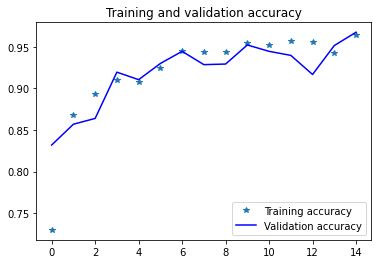

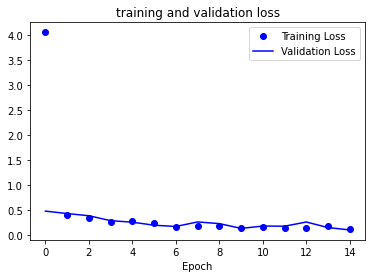

In [ ]:
# LBL6 Построение графиков, визуализирующих процесс обучения 
# (график зависимости функции потерь от номера эпохи обучения, и т.п.)
model.train_plot(2)

LBL 10 Автоматическое сохранение и визуализация результатов тестирования

In [ ]:
# Save train_samll model
model.save("train_samll")

In [ ]:
#test on test_small
test_res = model.test_on_dataset(d_test_small,0.2)
Metrics.print_all(d_test_small.labels[:len(test_res)],test_res, 'test 20% test_small')

  0%|          | 0/360 [00:00<?, ?it/s]

metrics for test 20% test_small:
	 accuracy 0.9833:
	 balanced accuracy 0.9831:


# Load the pretrained model "train_small" and Trian it on full Dataset d_train

In [ ]:
#LBL4 Загрузка модели с какой-то конкретной итерации обучения (если используется итеративное обучение)
units_dense=128;int_drop=0.3;if_add_dense = False
model = Model(units_dense,int_drop,if_add_dense)

In [ ]:
model.load('train_small')

In [ ]:
## Trian on full dataset
model.train(d_train,True)

training started
Epoch 1/5


2022-11-22 18:22:34.371745: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-22 18:22:37.180203: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


450/450 - 44s - loss: 0.6295 - accuracy: 0.8556 - val_loss: 0.4781 - val_accuracy: 0.9061 - 44s/epoch - 99ms/step
Epoch 2/5
450/450 - 31s - loss: 0.6404 - accuracy: 0.8879 - val_loss: 0.5437 - val_accuracy: 0.9100 - 31s/epoch - 70ms/step
Epoch 3/5
450/450 - 31s - loss: 0.6808 - accuracy: 0.8935 - val_loss: 0.5963 - val_accuracy: 0.9150 - 31s/epoch - 69ms/step
Epoch 4/5
450/450 - 31s - loss: 0.7428 - accuracy: 0.8952 - val_loss: 0.5412 - val_accuracy: 0.9239 - 31s/epoch - 69ms/step
Epoch 5/5
450/450 - 30s - loss: 0.7269 - accuracy: 0.8998 - val_loss: 0.5331 - val_accuracy: 0.9236 - 30s/epoch - 67ms/step
Second Training started
Epoch 1/15


450/450 - 90s - loss: 0.4843 - accuracy: 0.8565 - val_loss: 0.2974 - val_accuracy: 0.9036 - 90s/epoch - 201ms/step
Epoch 2/15
450/450 - 76s - loss: 0.2025 - accuracy: 0.9357 - val_loss: 0.1537 - val_accuracy: 0.9492 - 76s/epoch - 168ms/step
Epoch 3/15
450/450 - 72s - loss: 0.1684 - accuracy: 0.9497 - val_loss: 0.2016 - val_accuracy: 0.9336 - 72s/epoch - 161ms/step
Epoch 4/15
450/450 - 74s - loss: 0.1639 - accuracy: 0.9503 - val_loss: 0.1000 - val_accuracy: 0.9706 - 74s/epoch - 165ms/step
Epoch 5/15
450/450 - 72s - loss: 0.1565 - accuracy: 0.9544 - val_loss: 0.1367 - val_accuracy: 0.9569 - 72s/epoch - 161ms/step
Epoch 6/15
450/450 - 74s - loss: 0.1221 - accuracy: 0.9604 - val_loss: 0.0801 - val_accuracy: 0.9744 - 74s/epoch - 165ms/step
Epoch 7/15
450/450 - 73s - loss: 0.1064 - accuracy: 0.9674 - val_loss: 0.1194 - val_accuracy: 0.9619 - 73s/epoch - 161ms/step
Epoch 8/15
450/450 - 74s - loss: 0.1074 - accuracy: 0.9676 - val_loss: 0.0692 - val_accuracy: 0.9786 - 74s/epoch - 164ms/step
Epo

In [ ]:
model.save("best")

INFO:tensorflow:Assets written to: drive/MyDrive/best/assets


INFO:tensorflow:Assets written to: drive/MyDrive/best/assets


In [ ]:
## Free Version Colab can not train on full Dataset due to the RAM limited 
## so i use RTX3090 in AutoDL to train this model 

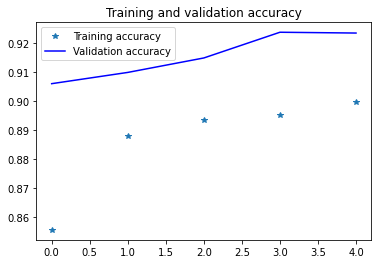

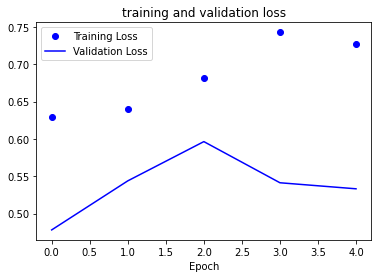

In [ ]:
model.train_plot(1)

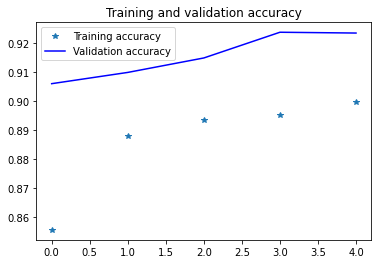

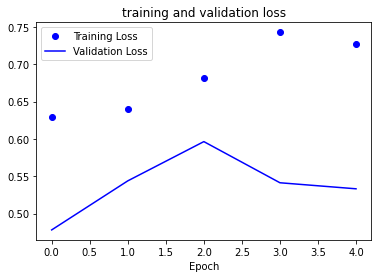

In [ ]:
model.train_plot(2)

Пример тестирования модели на части набора данных:

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

Пример тестирования модели на полном наборе данных:

In [ ]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [ ]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru. 

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb 

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"